In [1]:
#!/usr/bin/env python3
import argparse
import matplotlib
import matplotlib.axes
import matplotlib.cm
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
import json
import wandb  # Added import for WandB
import numpy
import numpy.typing
import numpy as np
import pickle
import os, sys

os.environ['NUMEXPR_MAX_THREADS'] = '32'
lib_path = os.path.abspath(os.path.join('..'))
sys.path.append(lib_path)

from report_generator.traj_loading import load_model_traj_npy, ModelTraj
from report_generator.tica_plots import TicaModel, calc_atom_distance, transform_tica_datas
from report_generator.reaction_coordinate import calc_reaction_coordinate, ReactionCoordKde
from report_generator.contact_maps import make_contact_map_plot, make_contact_map, ContactMap
from report_generator.bond_and_angle_analysis import plot_bond_length_angles, get_bond_angles
from report_generator.kullback_leibler_divergence import kl_divergence, wasserstein
import scipy
import time
import mdtraj
from tabulate import tabulate

def runReport(benchmark, test_run, also_plot_locally) -> None:
    with open(benchmark) as f:
        benchmark_data = json.loads(f.read())
        
        model_path = benchmark_data["model_path"]
        for protein_name, info in benchmark_data["proteins"].items():
            print('Processing protein: ', protein_name)
            protein_name: str
            model_trajs: list[ModelTraj] = load_model_traj_npy(info["model_npy_path"])
            
            with open(info["tica_model"], 'rb') as tica_model_file:
                # with open(info["all_native_file_strided"], 'rb') as all_native_file_strided:
                with open("/media/DATA_18_TB_1/andy/benchmark_cache/chignolin_native_trajs_CG_stride1_nrNativePaths373_300K.pkl", 'rb') as all_native_file_strided:
                    tica_model = pickle.load(tica_model_file)
                    native_trajs_strided = pickle.load(all_native_file_strided)

                    csv_file = "../save_energies.csv"  
                
                    df = load_csv(csv_file)
                    print("DataFrame loaded successfully.\n")
                    
                    make_figs(protein_name, model_trajs, native_trajs_strided, tica_model, df)


In [2]:
import pandas as pd
import numpy as np
import ast

def load_csv(csv_path):
    """
    Loads the CSV file with columns: path, data, mean, std, min, max.
    Converts the 'data' column from a string representation of a NumPy array
    into an actual NumPy array.

    :param csv_path: Path to the CSV file.
    :return: A pandas DataFrame with 'data' as NumPy arrays.
    """
    # Read the CSV into a DataFrame
    df = pd.read_csv(csv_path)

    # Convert the data column (string) into an actual NumPy array
    def string_to_array(data_str):
        """
        Safely convert string to a NumPy array.
        """
        data_str = data_str.replace('\n', ', ')
        # Use ast.literal_eval to parse Python-like list/array strings
        arr = ast.literal_eval(data_str)  
        return np.array(arr)

    # Apply the conversion to the 'data' column
    df['data'] = df['data'].apply(string_to_array)

    return df

In [3]:
def energy_grid(native_proj_datas_concat):
    # Suppose you have your data array of shape (N, T_N), 
    data = native_proj_datas_concat 

    x = data[:, 0]  # First component
    y = data[:, 1]  # Second component
    
    # 1) Define bin edges for x and y.
    num_bins = 19
    x_bins = np.linspace(np.min(x), np.max(x), num_bins )
    y_bins = np.linspace(np.min(y), np.max(y), num_bins )
    
    # 2) Digitize x and y separately:
    x_indices = np.digitize(x, x_bins)
    y_indices = np.digitize(y, y_bins)
    
    bin_data = [[[] for _ in range(num_bins + 1)] for _ in range(num_bins + 1)]
    
    for i in range(len(x)):
        bx = x_indices[i]
        by = y_indices[i]
        bin_data[bx][by].append(i)
    
    # Now bin_data[bx][by] is a Python list of all data rows that landed in that bin.
    # You can optionally convert each to a numpy array if needed:
    # for bx in range(num_bins + 1):
    #     for by in range(num_bins + 1):
    #         bin_data[bx][by] = np.array(bin_data[bx][by])  # shape (num_points_in_bin, 45)

    return x_bins, y_bins, bin_data


In [4]:
def make_figs(protein_name, model_trajs_all: list[ModelTraj], 
              native_trajs_strided: list[ModelTraj], tica_model: TicaModel, df) -> None:
    # Create a single figure
    plt.figure(figsize=(8, 6))
    plt.title(protein_name, fontsize=16)

    print("Take out the first 10%% of frames in model_trajs in order not to bias the model towards the starting points")
    start_time = time.time()
    print('model_trajs', len(model_trajs_all), model_trajs_all[0].trajectory.n_frames)

    # Remove the first 10% of frames from all model trajectories
    trajLen = model_trajs_all[0].trajectory.n_frames
    model_trajs = [t.filterFrames(start=int(trajLen / 10) - 1, end=-1) for t in model_trajs_all]
    print('model_trajs', len(model_trajs), model_trajs[0].trajectory.n_frames)

    # Remove any trajectories that contain NaNs
    for t, traj in enumerate(model_trajs.copy()):
        if np.isnan(traj.trajectory.xyz).any():
            print(f"{protein_name} model traj {t} has nans, removing it")
            model_trajs.pop(t)

    # Transform the model trajectories into TICA space
    model_tica_datas = transform_tica_datas(
        tica_model, [calc_atom_distance(x.trajectory) for x in model_trajs]
    )
    print('model_tica_datas', len(model_tica_datas), model_tica_datas[0].shape)
    model_projected_data = np.concatenate(model_tica_datas)
    print('model_projected_data', model_projected_data.shape)

    for traj in model_trajs:
        assert not np.isnan(traj.trajectory.xyz).any()
        assert not np.isnan(calc_atom_distance(traj.trajectory)).any()

    assert not np.isnan(model_projected_data).any(), (
        "%d/%d nans found in model_projected_data" % 
        (np.isnan(model_projected_data).sum(), model_projected_data.size)
    )

    # Transform the native trajectories into TICA space
    native_proj_datas = transform_tica_datas(
        tica_model, [calc_atom_distance(x.trajectory) for x in native_trajs_strided]
    )
    # (Assuming transform_tica_datas returns arrays so that this check works.)
    for data in native_proj_datas:
        assert not np.isnan(data).any()

    strideNative = 10
    native_proj_datas_concat = np.concatenate(native_proj_datas)[::strideNative]
    assert not np.isnan(native_proj_datas_concat).any()
    print('native_proj_datas_concat', native_proj_datas_concat.shape)
    print("--- projected data %s seconds ---" % (time.time() - start_time))

    # Determine the plotting limits based on the data ranges
    xmin = np.min(model_projected_data[:, 0])
    xmax = np.max(model_projected_data[:, 0])
    ymin = np.min(model_projected_data[:, 1])
    ymax = np.max(model_projected_data[:, 1])

    xmin = np.min([xmin, np.min(native_proj_datas_concat[:, 0])])
    xmax = np.max([xmax, np.max(native_proj_datas_concat[:, 0])])
    ymin = np.min([ymin, np.min(native_proj_datas_concat[:, 1])])
    ymax = np.max([ymax, np.max(native_proj_datas_concat[:, 1])])

    x_bot = xmin - 0.1 * (xmax - xmin)
    x_top = xmax + 0.1 * (xmax - xmin)
    y_bot = ymin - 0.3 * (ymax - ymin)
    y_top = ymax + 0.1 * (ymax - ymin)

    for lim in (x_bot, x_top, y_bot, y_top):
        assert not np.isnan(lim)

    plt.xlim((x_bot, x_top))
    plt.ylim((y_bot, y_top))
    plt.xlabel("TIC0")
    plt.ylabel("TIC1")

    # Create a grid for the contour plot
    X, Y = np.mgrid[x_bot:x_top:50j, y_bot:y_top:50j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    strideModelTica2D = 1
    print('model_projected_data shape:', model_projected_data[:, :2].T.shape)
    # Estimate the density using a gaussian KDE for the model data (not used further here)
    model_kde_2d = scipy.stats.gaussian_kde(
        model_projected_data[::strideModelTica2D, :2].T
    )
    
    print('native_proj_datas_concat shape: ', native_proj_datas_concat.shape)
    # Compute the KDE for native data
    native_kde_2d = scipy.stats.gaussian_kde(
        native_proj_datas_concat[:, :2].T
    )
    Z_native_1D = native_kde_2d(positions)
    Z_native = np.reshape(Z_native_1D.T, X.shape)

    # Plot the contour for the native data in TICA space
    # Define levels (either as a number or a list of contour levels)
    levels = 10  # You can adjust or specify a list of levels if needed
    plt.contour(X, Y, Z_native, cmap=matplotlib.cm.Blues, linewidths=2, levels=levels)

    # ---- Added Scatter Plot for Native Data ----
    # Generate colors for each native projection replica using the viridis colormap.
    # colors = matplotlib.cm.ScalarMappable(cmap='viridis').to_rgba(
    #     np.linspace(0, 1, len(native_proj_datas))
    # )
    
    # start_time = time.time()
    # for r, (datas, c) in enumerate(zip(native_proj_datas, colors)):
    #     print(r)
    #         # Create a boolean mask for the desired range:
    #     # - The 0 component (x-values) between 1 and 2 (inclusive)
    #     # - The 1 component (y-values) between -0.5 and 1 (inclusive)
    #     x_min_w = 1
    #     x_max_w = 2
    #     y_min_w = -0.5
    #     y_max_w= 1
    #     mask = (datas[:, 0] >= x_min_w) & (datas[:, 0] <= x_max_w) & (datas[:, 1] >= y_min_w) & (datas[:, 1] <= y_max_w)
    #     original_indices = np.where(mask)[0]

    #     # Apply the mask to filter the points.
    #     filtered_datas = datas[mask]

    #     stride = 1000
    #     plt.scatter(filtered_datas[::stride, 0], filtered_datas[::stride, 1], color=c, s=7, alpha=1)
    #     print("Original frames in the mask:", original_indices)

    # plt.title("GT Points in TICA space")
    # %matplotlib inline
    # plt.show()
    # plt.clf()
    start_time = time.time()
    x_bins, y_bins, data = energy_grid(native_proj_datas_concat)

    num_x_bins = len(x_bins) - 1
    num_y_bins = len(y_bins) - 1
    mean_energy_grid = np.zeros((num_x_bins, num_y_bins))
    std_energy_grid = np.zeros((num_x_bins, num_y_bins))
    # 2) Loop over all bins in data to compute the mean energy
    for i in range(num_x_bins):
        for j in range(num_y_bins):
            box_indices = data[i][j]
            
            box_energy = []
            for p in box_indices:
                x = p // len(native_proj_datas)
                y = p % len(native_proj_datas)
                if (x < len(df)):
                    box_energy.append(df.iloc[x]['data'][y])
            
            if len(box_energy) > 0:
                mean_energy = np.mean(box_energy)
                std_energy = np.std(box_energy)
            else:
                # If no points, define it as NaN or some default
                mean_energy = np.nan  
                std_energy = np.nan
            
            mean_energy_grid[i, j] = mean_energy
            std_energy_grid[i, j] = std_energy
    
    # 3) Plot using pcolormesh (which takes bin edges + a 2D array of values)
    # plt.figure(figsize=(8,6))
    cmap = plt.cm.viridis  # or another colormap of your choice
    
    # pcolormesh expects the 2D array shape to match (num_x_bins, num_y_bins)
    pc = plt.pcolormesh(x_bins, y_bins, mean_energy_grid.T, cmap=cmap, shading='auto')
    # Note: We do .T above if mean_energy_grid is indexed [i, j] with i→x, j→y
    # because pcolormesh expects shape=(len(y)-1, len(x)-1) if you pass bins as x_bins, y_bins
    
    plt.colorbar(pc, label='Mean Energy')
    
    plt.title('Mean Energy per Box')

    # for r, (datas, c) in enumerate(zip(native_proj_datas, colors)):
    #     stride = 10
    #     plt.scatter(datas[::stride, 0], datas[::stride, 1], color=c, s=7, alpha=1)
    
    plt.xlim((x_bot, x_top))
    plt.ylim((y_bot, y_top))
    plt.xlabel("TIC0")
    plt.ylabel("TIC1")
    
    for xb in x_bins:
        plt.axvline(x=xb, color='k', linestyle='--', alpha=0.3)
    
    # Draw horizontal lines for each y-bin boundary:
    for yb in y_bins:
        plt.axhline(y=yb, color='k', linestyle='--', alpha=0.3) 
                    
    print("--- Scatter plot native data in %s seconds ---" % (time.time() - start_time))
    
    %matplotlib inline
    plt.show()


Processing protein:  chignolin
mdtraj_list 20 <mdtraj.Trajectory with 100 frames, 10 atoms, 10 residues, without unitcells>
DataFrame loaded successfully.

Take out the first 10%% of frames in model_trajs in order not to bias the model towards the starting points
model_trajs 20 100
model_trajs 20 90
model_tica_datas 20 (90, 45)
model_projected_data (1800, 45)
native_proj_datas_concat (373000, 45)
--- projected data 121.41146087646484 seconds ---
model_projected_data shape: (2, 1800)
native_proj_datas_concat shape:  (373000, 45)
--- Scatter plot native data in 4.285264253616333 seconds ---


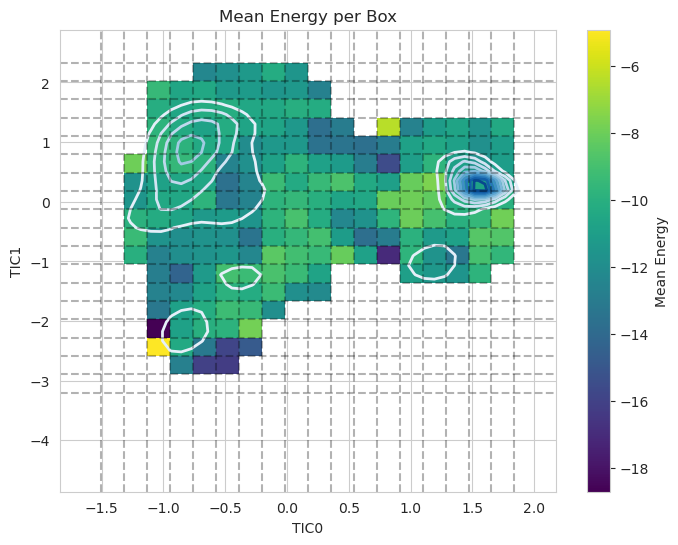

In [5]:
benchmark = "/media/DATA_18_TB_1/benchmark_sims/000206_results_0_1.0/benchmark.json"
runReport(benchmark, False, False)